In [1]:
import numpy as np
import matplotlib.pyplot as plt

import src.cryogenv.sim.cryosim as cryo


In [2]:
test_sim = cryo.Cryosim(record_length=2**14, sample_frequency=50e3, default=True)

Heater initialized with R_H = 0.01 Ohms
TES initialized with model=sigmoid, R_max=0.05 Ohm, T_mid=0.035 K
ETM initialized as 2-component model with parameters: C_e=2.2e-11, C_a=1.5e-10, G_eb=7.5e-09, G_ea=1.4e-10, G_ab=5e-09, T_b=0.015, R_S=0.05, L=4e-07, V_B=5e-06
SQUID initialized with model=FLL_simple,M_f = ..., R_f=100000.0.
Noise applied.
Cryogenic simulation initialized with default components.


In [3]:
test_sim.show_modules()


{'heater': {'R_H': 0.01, 'V_H': 1e-06},
 'tes': {'model': 'sigmoid', 'R_max': 0.05, 'T_mid': 0.035},
 'etm': {'n_comp': 2,
  'C_e': 2.2e-11,
  'C_a': 1.5e-10,
  'G_eb': 7.5e-09,
  'G_ea': 1.4e-10,
  'G_ab': 5e-09,
  'T_b': 0.015,
  'R_S': 0.05,
  'L': 4e-07,
  'V_B': 5e-06},
 'squid': {'model': 'FLL_simple',
  'R_f': 100000.0,
  'M_in': 4.704545454545455e-09,
  'M_f': 2.7972972972972976e-10}}

In [13]:
# Set new values (Heater, heater_tp and bias are necessary!)
test_sim.set_heater(1.2e-6)         # DAC
test_sim.set_heater_tp(tp_amplitude=7e-9) # TPA
test_sim.set_bias(bias_voltage=1e-6)    # TES bias

# After setting new values, you have to solve the ode's once again! 
test_sim.solve()    # Get all values updated

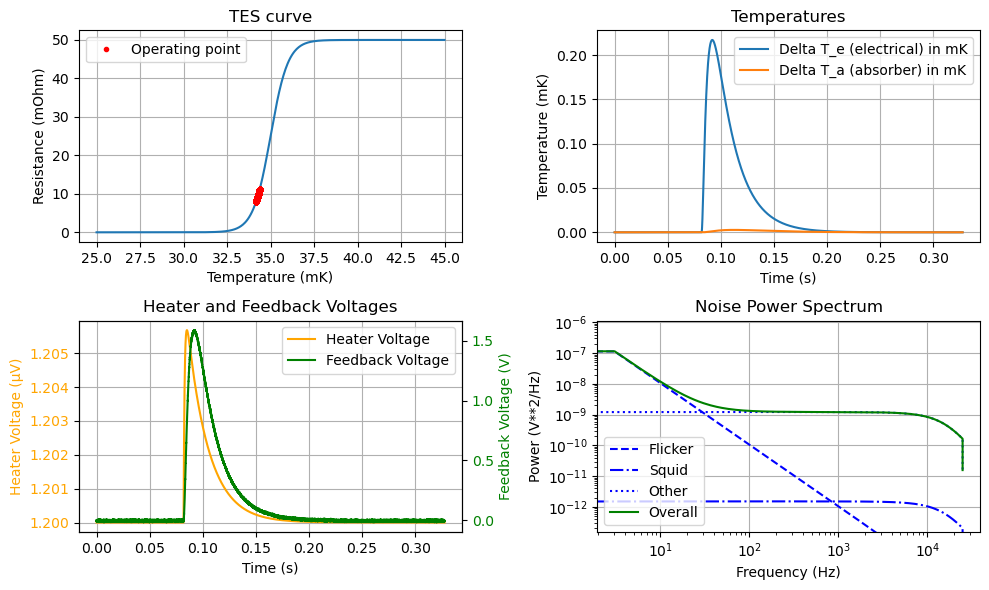

In [14]:
test_sim.render()

# Example 1: Do a heater sweep with constant testpulses

In [6]:
# Set constant TP amplitude
test_sim.set_heater_tp(tp_amplitude=25e-9) # TPA
test_sim.set_bias(1.5e-6)

heater_values = np.linspace(1.1e-6, 1.3e-6, 12)
PH_list = []
for i in heater_values:
    test_sim.set_heater(i)
    test_sim.solve()
    PH_list.append(np.max(test_sim.I_T)-np.min(test_sim.I_T))

KeyboardInterrupt: 

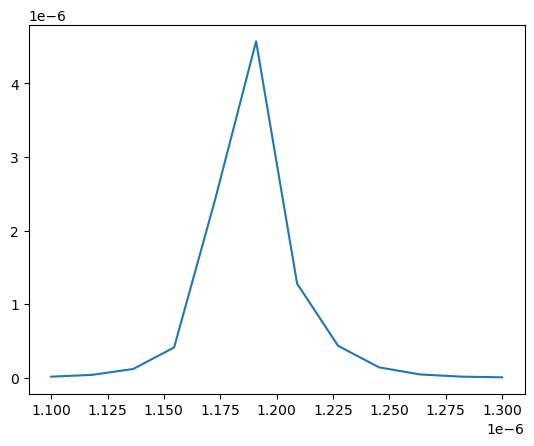

In [ ]:
plt.plot(heater_values, PH_list)